# Optimization patterns

Not every model is a linear regression with a closed form optimizer.
In this recipe, we will compare a few different patterns that JAX can power to optimize any differentiable function.
We'll cover the following topics:
1. Gradient Descent
2. BFGS
3. Newton method



In [341]:
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy.optimize as jso
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")


## Running example: logistic regression

Let's use a logistic regression as an example of a well-behaved (i.e. convex) optimization problem that does not admit a closed-form optimizer.
We will discuss less well-behaved problems at the end.

Given fixed $X$ and $\beta$ (which we will synthesized respectively from a correlated and standard normal distributions), we define $p(X)  = \frac{1}{1 + exp(-X\beta)}$.

From this let $y \sim \text{Bernoulli}(p(X))$.

Let's use JAX to sample this synthetic dataset:

In [19]:
key = random.PRNGKey(20220521)
key, *skeys = random.split(key, 4)

n = 10_000
p = 4

beta = random.normal(skeys[0], (p, ))
x = random.multivariate_normal(
    skeys[1],
    mean=jnp.zeros(p),
    cov=jnp.array([
        [1.0, 0.8, 0.7, 0.0],
        [0.8, 1.0, 0.6, 0.0],
        [0.7, 0.6, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ]), # First 3 predictors are positively correlated
    shape=(n,),
)

p_x = jax.nn.sigmoid(x @ beta)
y = random.bernoulli(skeys[2], p_x).astype(int)

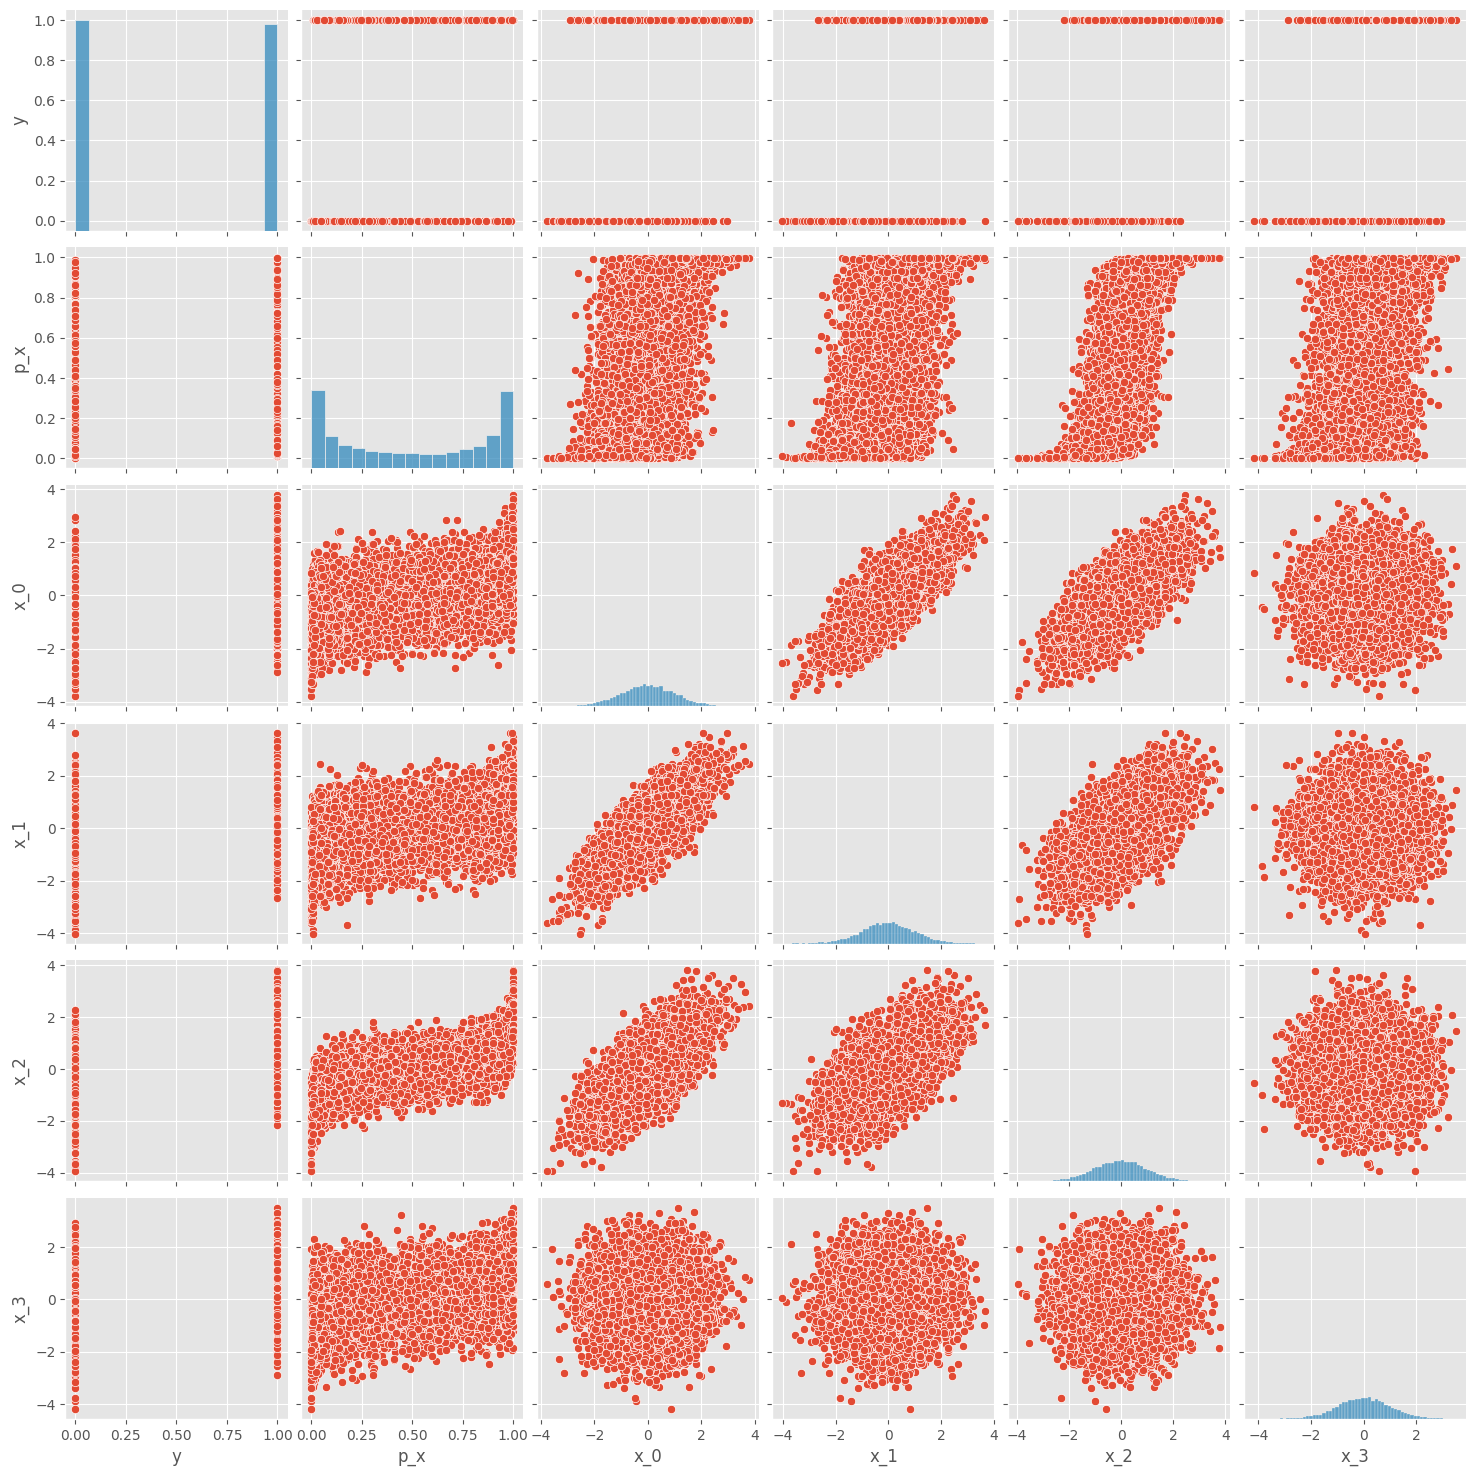

In [20]:
df = pd.DataFrame({
    'y': y,
    'p_x': p_x,
    **{f'x_{i}': x[:, i] for i in range(p)}
})
sns.pairplot(df)
plt.show()

Before performing any sort of optimization, always make sure that predictors and responses are normalized to a scale that is around 1. Otherwise, any optimization algorithm can run into numerical instabilities.

Here, we are good since predictors and parameters have been generated with a variance of 1.

Let's use negative likelihood as loss function to fit the model:


In [25]:
def loss(beta, x, y):
    p_hat = jax.nn.sigmoid(x @ beta)
    loglik = jax.scipy.stats.bernoulli.logpmf(y, p_hat)
    return -loglik.mean()

print(f"Loss at true beta: {loss(beta, x, y)=}")

Loss at true beta: loss(beta, x, y)=DeviceArray(0.35847148, dtype=float32)


## Gradient Descent

Though maybe not as loved by statisticians, let's start with every machine learner's favorite algorithm, gradient descent.
It is nonetheless a very robust algorithm that can handle a wide variety of situation and that becomes unavoidable when the number of parameter gets large.


### "Vanilla" gradient descent

For reference, let's write our own gradient descent first:

In [113]:
%%time
def fit_beta_gd(x, y):
    n_iterations = 10_000
    lr = 3.0
    g_tol = 1e-6

    beta = jnp.zeros(p)
    hist = {'f': [], 'g_norm': []}
    
    @jax.jit
    def update(beta):
        f, g = jax.value_and_grad(loss)(beta, x, y)
        beta = beta - lr * g
        return beta, f, jnp.linalg.norm(g)
    
    for i in range(n_iterations):
        beta, f, g_norm = update(beta)
        hist['f'].append(f)
        hist['g_norm'].append(g_norm)
        if g_norm < g_tol:
            break
    
    hist['f'] = jnp.stack(hist['f'])
    hist['g_norm'] = jnp.stack(hist['g_norm'])
    
    return beta, hist

beta_gd, hist = fit_beta_gd(x, y)

CPU times: user 241 ms, sys: 19.8 ms, total: 261 ms
Wall time: 205 ms


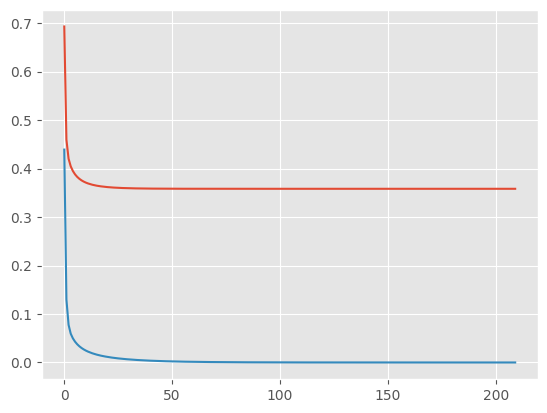

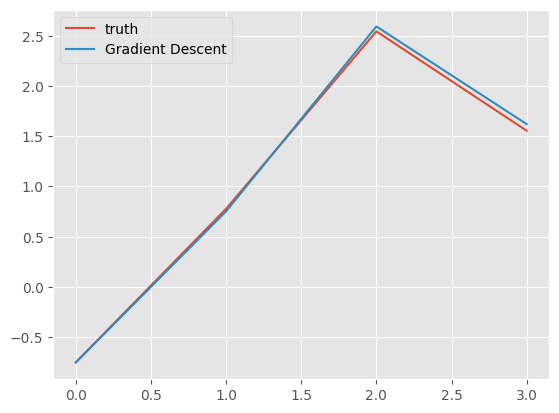

In [111]:
plt.plot(hist['f'])
plt.plot(hist['g_norm'])
plt.show()
plt.plot(beta, label='truth')
plt.plot(beta_gd, label='Gradient Descent')
plt.legend()
plt.show()

We chose the maximum learning rate allowing stable convergence. Here it is quite higher than typical learning rates because the model is simple. More complex models can benefit from the stability provided by a lower learning rate. Note that we start with $\beta=0$ since the model is identifiable and not degenerate. For non-identifiable models (typically neural networks, or colinear predictors) it is important to initialize $\beta$ randomly to break symmetries.

Once fitted, we can see that the estimated beta is close to the real one. We will see how to test for statistical significance later in this recipe.


### Adaptative gradient descent

JAX can also be used to build adaptative gradient procedures such as Adam, that will make the choice of the learning rate less important.
For this we will leverage the `optax` library which is build on top of JAX.


In [130]:
%%time

def fit_beta_agd(x, y):
    n_iterations = 10_000
    lr = 0.3
    g_tol = 1e-6

    beta = jnp.zeros(p)
    hist = {'f': [], 'g_norm': []}
    
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(beta)

    @jax.jit
    def step(beta, opt_state):
        f, g = jax.value_and_grad(loss)(beta, x, y)
        updates, opt_state = optimizer.update(g, opt_state, beta)
        beta = optax.apply_updates(beta, updates)
        return beta, opt_state, f, jnp.linalg.norm(g)

    for i in range(n_iterations):
        beta, opt_state, f, g_norm = step(beta, opt_state)
        hist['f'].append(f)
        hist['g_norm'].append(g_norm)
        if g_norm < g_tol:
            break

    return beta, hist

beta_agd, hist = fit_beta_agd(x, y)

CPU times: user 227 ms, sys: 31 ms, total: 258 ms
Wall time: 200 ms


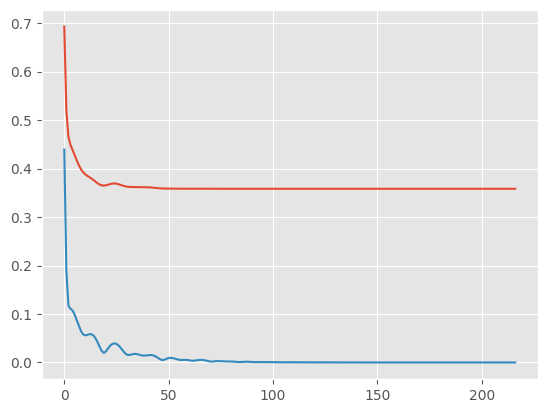

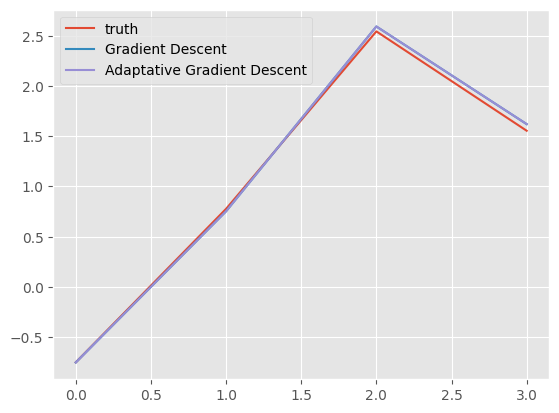

In [132]:
plt.plot(hist['f'])
plt.plot(hist['g_norm'])
plt.show()
plt.plot(beta, label='truth')
plt.plot(beta_gd, label='Gradient Descent')
plt.plot(beta_agd, label='Adaptative Gradient Descent')
plt.legend()
plt.show()

The convergence plot is not motonically decreasing, which is typical of algorithms that have any sort of momentum term in the gradient updates.

We can see that both vanilla and adaptative gradient descent algorithms converge to the same value in about the same amount of iterations and wall time. Adam is usually very useful for large neural network and requires less tuning than standard gradient descent. It is therefore a good tool to keep handy.


## BFGS Algorithm

JAX provides its own version of BFGS provided by `jax.scipy.optimize.minimize` similarly to scipy.

However, on the contrary to scipy, thanks to JAX automatic differentiation, jacobian evaluation is evaluated directly instead of the finite method employed by scipy. This is significantly more scalable when $p$ gets larger (as computing a gradient by finite difference requires $O(p)$ function evaluations). It is also significantly more numerically accurate, since any inaccuracy in the finite difference would result in inaccuracies in the optimization scheme. To achieve the same level of accuracy with scipy, the analyst would have to write their own gradient function and provide it to the `minimize` function. This is not doable if the function being optimized gets too complicated.

Also, note that JAX `minimize` can be JIT-compiled and vectorized, making it is easy to solve batches of optimization problems. This is not easily done with scipy or other deep learning frameworks such as Tensorflow.

In [143]:
%%time

@jax.jit
def fit_beta_BFGS(x, y):
    bfgs_results = jso.minimize(loss, jnp.zeros(p), args=(x, y), method="BFGS")
    return bfgs_results

bfgs_results = fit_beta_BFGS(x, y)
beta_bfgs = bfgs_results.x


CPU times: user 869 ms, sys: 0 ns, total: 869 ms
Wall time: 843 ms


In [161]:
%%time
bfgs_results = fit_beta_BFGS(x, y)
beta_bfgs = bfgs_results.x
bfgs_results

CPU times: user 2.15 ms, sys: 788 µs, total: 2.94 ms
Wall time: 1.66 ms


OptimizeResults(x=DeviceArray([-0.752961 ,  0.7530602,  2.5934875,  1.6210223], dtype=float32), success=DeviceArray(True, dtype=bool), status=DeviceArray(0, dtype=int32, weak_type=True), fun=DeviceArray(0.3583041, dtype=float32), jac=DeviceArray([ 1.7940765e-07,  4.2759680e-06, -2.7316601e-06,
             -1.5771842e-07], dtype=float32), hess_inv=DeviceArray([[ 30.91601  , -19.310888 , -15.5330715,  -4.715713 ],
             [-19.310888 ,  23.777905 ,   2.4743295,   3.0588417],
             [-15.5330715,   2.474327 ,  35.332504 ,  12.93342  ],
             [ -4.7157135,   3.0588424,  12.933419 ,  15.54867  ]],            dtype=float32), nfev=DeviceArray(23, dtype=int32, weak_type=True), njev=DeviceArray(23, dtype=int32, weak_type=True), nit=DeviceArray(22, dtype=int32, weak_type=True))

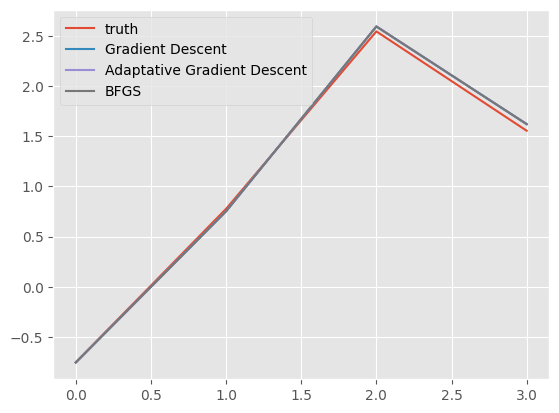

In [144]:
plt.plot(beta, label='truth')
plt.plot(beta_gd, label='Gradient Descent')
plt.plot(beta_agd, label='Adaptative Gradient Descent')
plt.plot(beta_bfgs, label='BFGS')
plt.legend()
plt.show()

After jit compilation (which lasts about 800ms), solving the problem takes about 2ms, making it very suitable to repeat experiments, bootstrap, etc.
BFGS agrees with gradient descent methods on the optimizer.


## Write your own Newton Method

When I saw the performance and accuracy boost that automatic differentiation can provide to an algorithm like BFGS, it made me wonder if using the same philosophy on second order methods (like Newton method) would work.
Note that a basic Newton method such as the one presented here only works on strongly convex problems, and use of it on problems that are not strictly convex (looking at you lasso regression) may lead to saddle points or straight up divergence.
Luckily, logistic regression is indeed strictly convex if the predictors are not colinear.



In [257]:
from typing import Callable, NamedTuple, Optional, Union
from jax import lax

# Inspired by JAX implementation of BFGS: https://github.com/google/jax/blob/main/jax/_src/scipy/optimize/bfgs.py

class _NewtonResults(NamedTuple):
    """Results from optimization.
    Parameters:
    converged: True if minimization converged.
    k: integer the number of iterations.
    nfev: integer total number of objective evaluations performed.
    ngev: integer total number of jacobian evaluations
    nhev: integer total number of hessian evaluations
    x_k: array containing the last argument value found during the search. If
    the search converged, then this value is the argmin of the objective
    function.
    f_k: array containing the value of the objective function at `x_k`. If the
    search converged, then this is the (local) minimum of the objective
    function.
    g_k: array containing the gradient of the objective function at `x_k`. If
    the search converged the l2-norm of this tensor should be below the
    tolerance.
    H_k: array containing the inverse of the Hessian.
    """
    converged: Union[bool, jnp.ndarray]
    k: Union[int, jnp.ndarray]
    nfev: Union[int, jnp.ndarray]
    ngev: Union[int, jnp.ndarray]
    nhev: Union[int, jnp.ndarray]
    x_k: jnp.ndarray
    f_k: jnp.ndarray
    g_k: jnp.ndarray
    H_k: jnp.ndarray


def minimize_newton(fun,
                    x0,
                    maxiter=None,
                    norm=jnp.inf,
                    gtol=1e-5):
    if maxiter is None:
        maxiter = jnp.size(x0) * 200

    f = fun
    df = jax.grad(f)
    d2f = jax.hessian(f)
    
    f_0 = f(x0)
    g_0 = df(x0)
    H_0 = d2f(x0)
    
    def has_converged(g, gtol):
        return  jnp.linalg.norm(g, ord=norm) < gtol
    
    state = _NewtonResults(
        converged=has_converged(g_0, gtol),
        k=0,
        nfev=1,
        ngev=1,
        nhev=1,
        x_k=x0,
        f_k=f_0,
        g_k=g_0,
        H_k=H_0,
    )
    
    def cond_fun(state):
        return (jnp.logical_not(state.converged)
                & (state.k < maxiter))
    
    def body_fun(state):
        p_k = -jnp.linalg.solve(state.H_k, state.g_k)
        x_kp1 = state.x_k + p_k
        
        f_kp1 = f(x_kp1)
        g_kp1 = df(x_kp1)
        H_kp1 = d2f(x_kp1)
        
        converged = has_converged(g_kp1, gtol)

        state = state._replace(
            converged=converged,
            k=state.k + 1,
            nfev=state.nfev + 1,
            ngev=state.ngev + 1,
            nhev=state.nhev + 1,
            x_k=x_kp1,
            f_k=f_kp1,
            g_k=g_kp1,
            H_k=H_kp1,
        )
        return state

    state = lax.while_loop(cond_fun, body_fun, state)
    return state


@jax.jit
def fit_beta_newton(x, y):
    beta = jnp.zeros(p)
    f = lambda beta: loss(beta, x, y)
    return minimize_newton(f, beta, 10)


newton_results = fit_beta_newton(x, y)

In [342]:
%%time
newton_results = fit_beta_newton(x, y)
beta_newton = newton_results.x_k
newton_results

CPU times: user 8.52 ms, sys: 734 µs, total: 9.25 ms
Wall time: 2.78 ms


_NewtonResults(converged=DeviceArray(True, dtype=bool), k=DeviceArray(5, dtype=int32, weak_type=True), nfev=DeviceArray(6, dtype=int32, weak_type=True), ngev=DeviceArray(6, dtype=int32, weak_type=True), nhev=DeviceArray(6, dtype=int32, weak_type=True), x_k=DeviceArray([-0.7529169,  0.7529522,  2.593537 ,  1.6210217], dtype=float32), f_k=DeviceArray(0.3583041, dtype=float32), g_k=DeviceArray([-7.2991276e-07, -7.5581926e-07, -1.1015924e-06,
             -6.8346668e-07], dtype=float32), H_k=DeviceArray([[ 0.08651333,  0.06214451,  0.03981939, -0.02316055],
             [ 0.06214451,  0.08411707,  0.02620903, -0.02238941],
             [ 0.03981939,  0.02620903,  0.05399181, -0.03779038],
             [-0.02316055, -0.02238941, -0.03779038,  0.0879974 ]],            dtype=float32))

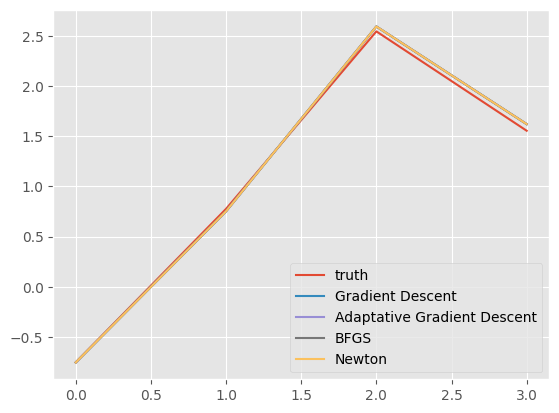

In [343]:
plt.plot(beta, label='truth')
plt.plot(beta_gd, label='Gradient Descent')
plt.plot(beta_agd, label='Adaptative Gradient Descent')
plt.plot(beta_bfgs, label='BFGS')
plt.plot(beta_newton, label='Newton')
plt.legend()
plt.show()

Once again all methods agree on the optimizer, which is an advantage of convex problems.

### Code explanation

If this Newton method looked a little more cryptic, this is normal as it uses more advanced JAX primitives and concepts.
The results are defined as a named tuple, because the control flow that we will use necessitates the use of a single state variable that holds all relevant information.

Secondly, 
```
    df = jax.grad(f)
    d2f = jax.hessian(f)
```
uses JAX automatic differentiation to efficiently and exactly compute gradients and hessians.

The control flow uses the `lax` primitive:
```
state = lax.while_loop(cond_fun, body_fun, state)
```
which is functionally equivalent to:
```
while cond_fun(state):
    state = body_fun(state)
```
This allows JAX to compile the function if needed and even take gradients (in forward-mode of automatic differentiation).
This type of capability can be very important for scientific machine learning, which benefits from taking gradients of complex business logic, such as differential equation solvers.

See https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#control-flow for more on control flow.

You can find the actual Newton algorithm in `body_fun`:
```
        p_k = -jnp.linalg.solve(state.H_k, state.g_k)
        x_kp1 = state.x_k + p_k
```
The rest is simple bookkeeping of variables of interest.


## Inspecting the Hessian

Since we have seen that all methods give us the same optimizer, we will just pick one and denote it $\hat\beta$.
Thanks to JAX automatic differentiation, we can easily access the hessian at the optimizer and inspect it.

Note that examination of the Hessian here is entirely independent of the chosen optimization algorithm.
To emphasize this point, we will inspect the hessian at the optimizer found by gradient descent, which obviously did not leverage the hessian during optimization.


In [333]:
beta_hat = beta_gd
H_hat = jax.hessian(loss)(beta_hat, x, y)
iH_hat = jnp.linalg.inv(H_hat)

From there, we can test a few things:
- are we at a local minimum? All eigenvalues of the hessian should be positive (assuming gradient is zero).
- is the inverse hessian estimated by BFGS accurate?
- what are the standard error since we maximized likelihood?


In [338]:
print("Is at local minimum: ", jnp.all(jnp.linalg.eigvalsh(H_hat) > 0))

Is at local minimum:  True


In [339]:
print(iH_hat)
print(bfgs_results.hess_inv)
print((iH_hat - bfgs_results.hess_inv) / iH_hat)

[[ 32.637505  -19.787813  -17.123253   -3.7981389]
 [-19.787815   26.056252    4.2037773   3.2267854]
 [-17.123243    4.2037683  38.179874   12.959151 ]
 [ -3.7981343   3.2267814  12.959148   16.750694 ]]
[[ 30.91601   -19.310888  -15.5330715  -4.715713 ]
 [-19.310888   23.777905    2.4743295   3.0588417]
 [-15.5330715   2.474327   35.332504   12.93342  ]
 [ -4.7157135   3.0588424  12.933419   15.54867  ]]
[[ 0.0527459   0.02410195  0.09286678 -0.24158521]
 [ 0.02410205  0.08743955  0.4114033   0.05204676]
 [ 0.09286627  0.41140258  0.07457778  0.00198555]
 [-0.24158682  0.05204535  0.00198541  0.07175968]]


BFGS inverse Hessian is loosely aligned with the exact one.

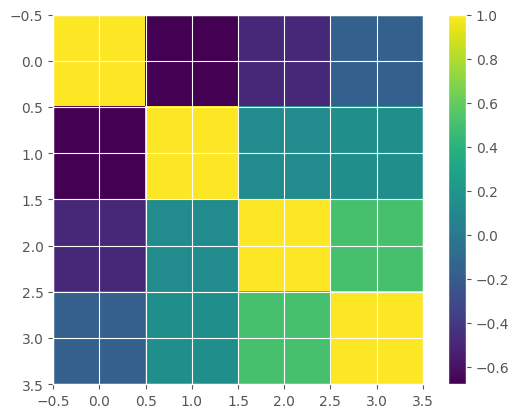

In [346]:
def get_cov(iH):
    # Division by n is due to the loss defined as -log_likelihood / n
    cov = iH / n
    beta_std = jnp.sqrt(jnp.diag(cov))
    corr = (cov / beta_std).T / beta_std
    return cov, beta_std, corr 

cov, beta_std, corr = get_cov(iH_hat)
plt.imshow(corr)
plt.colorbar()
plt.show()

In [347]:
_, beta_std_bfgs, _ = get_cov(bfgs_results.hess_inv)


(DeviceArray([0.05712924, 0.05104532, 0.06178987, 0.04092761], dtype=float32),
 DeviceArray([0.05560217, 0.04876259, 0.05944115, 0.0394318 ], dtype=float32))

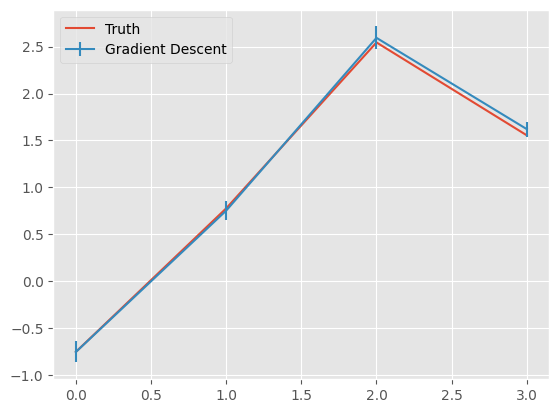

In [309]:
plt.plot(range(p), beta, label='Truth')
plt.errorbar(range(p), beta_gd, label='Gradient Descent', yerr= 1.96 * beta_std)
plt.legend()
plt.show()

The true estimate is indeed within standard error as inferred by the hessian.

We can validate those standard errors by bootstrap, similarly to the linear regression recipe:

In [327]:
%%time
def replicate(key, beta, x):
    p_x = jax.nn.sigmoid(x @ beta)
    y = random.bernoulli(key, p_x)
    beta_hat = fit_beta_BFGS(x, y)
    return beta_hat.x

n_replications = 1_000
key, skey = random.split(key)
skeys = random.split(skey, n_replications)

boostrap = jax.jit(jax.vmap(replicate, in_axes=(0, None, None)))
beta_s = boostrap(skeys, beta, x)
beta_std_bootstrap = beta_s.std(axis=0)

CPU times: user 28.6 s, sys: 359 ms, total: 29 s
Wall time: 7.1 s


Note that `jit` and `vmap` allows us to quickly compute a large batch of BFGS optimization.

In [351]:
# Std errors from 3 different methods:
beta_std, beta_std_bootstrap, beta_std_bfgs 

(DeviceArray([0.05712924, 0.05104532, 0.06178987, 0.04092761], dtype=float32),
 DeviceArray([0.05510296, 0.0501771 , 0.06092589, 0.04206798], dtype=float32),
 DeviceArray([0.05560217, 0.04876259, 0.05944115, 0.0394318 ], dtype=float32))

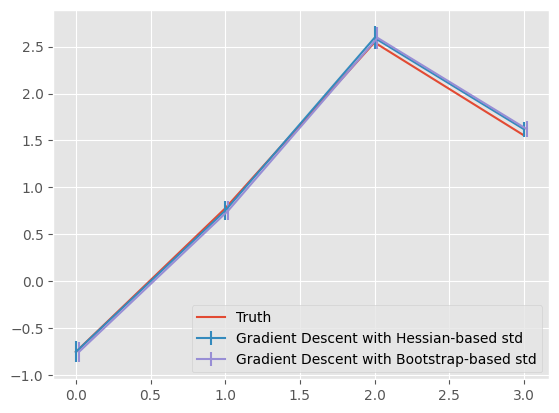

In [349]:
plt.plot(range(p), beta, label='Truth')
plt.errorbar(range(p), beta_gd, label='Gradient Descent with Hessian-based std', yerr= 1.96 * beta_std)
plt.errorbar(.02 + jnp.arange(p), beta_gd, label='Gradient Descent with Bootstrap-based std', yerr= 1.96 * beta_std_bootstrap)
plt.legend()
plt.show()

For all intents and purposes, Hessian-based inference is strictly equivalent to the bootstrap here. This should be the case as long as sample size is large and standard errors small. Otherwise bootstrap should be more accurate. BFGS is also close, but your mileage may vary.


## Conclusion

In this recipe, we have seen different patterns for optimization using JAX automatic differentiation:
1. Gradient descent, regular and adaptative
2. BFGS, provided directly by JAX
3. Newton method, wrote using JAX primitives

We have also leveraged JAX hessian computations to inspect the stability of the optimizer, confirming it was indeed a minimum, and computing standard errors for inference.
